Colunas disponíveis: ['unnamed: 0', 'series_title', 'released_year', 'certificate', 'runtime', 'genre', 'imdb_rating', 'overview', 'meta_score', 'director', 'star1', 'star2', 'star3', 'star4', 'no_of_votes', 'gross']

Estatísticas básicas:
       imdb_rating  meta_score  gross_numeric  runtime_numeric  num_stars
count   999.000000  842.000000   8.300000e+02       999.000000      999.0
mean      7.947948   77.969121   6.808257e+07       122.871872        4.0
std       0.272290   12.383257   1.098076e+08        28.101227        0.0
min       7.600000   28.000000   1.305000e+03        45.000000        4.0
25%       7.700000   70.000000   3.245338e+06       103.000000        4.0
50%       7.900000   79.000000   2.345744e+07       119.000000        4.0
75%       8.100000   87.000000   8.087634e+07       137.000000        4.0
max       9.200000  100.000000   9.366622e+08       321.000000        4.0

Correlação entre variáveis numéricas:
                 imdb_rating  meta_score  gross_numeric

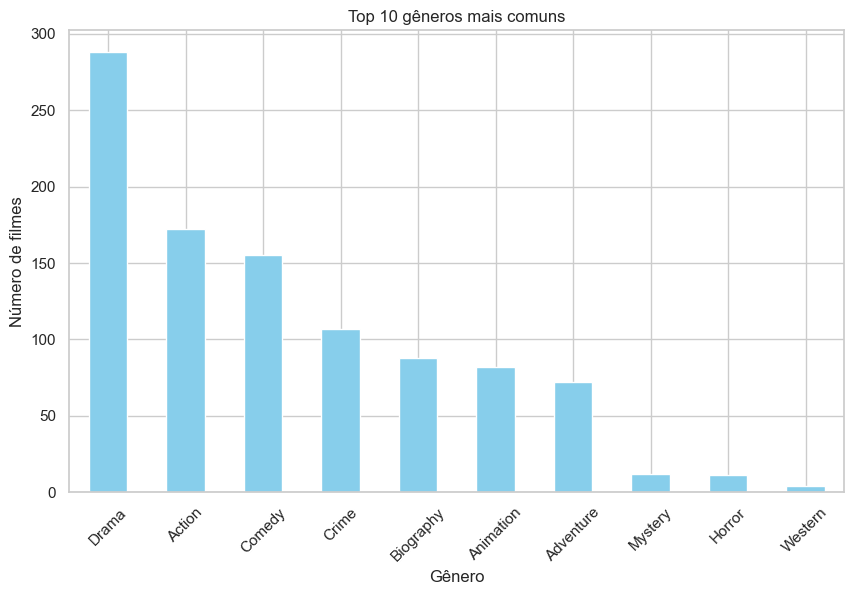

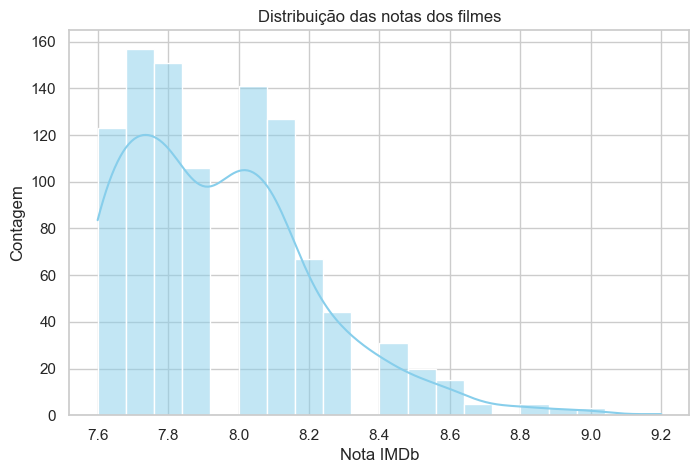

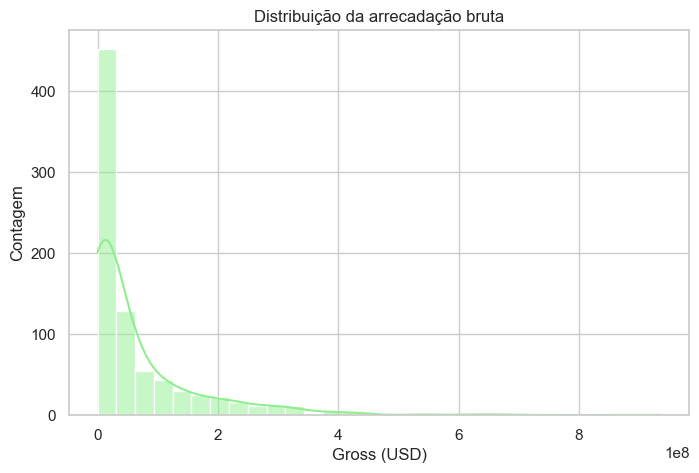

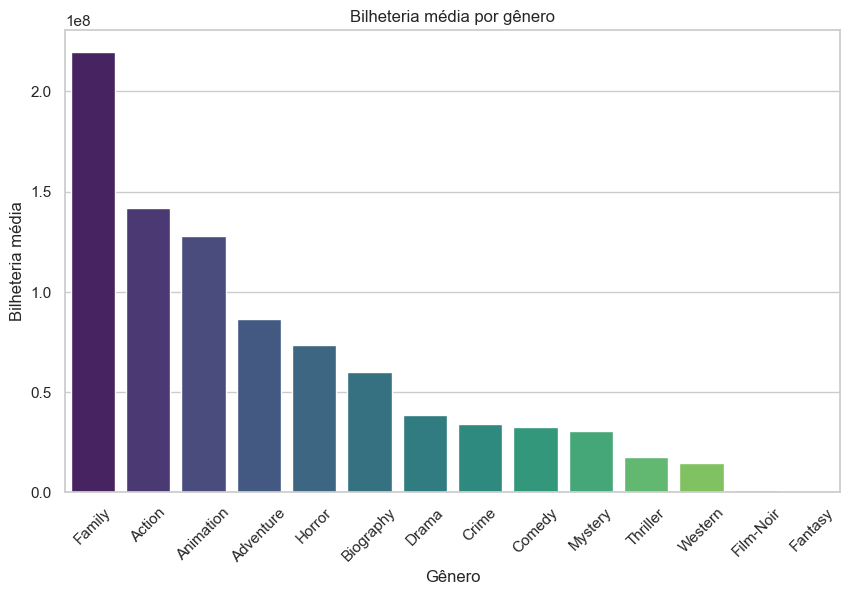

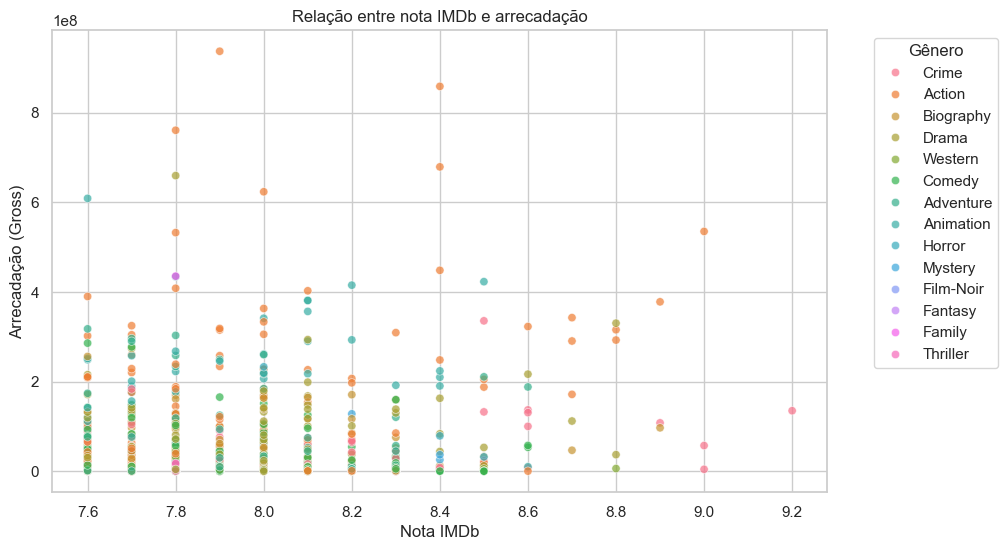


⭐ Nota prevista do IMDb para o filme: 7.91
RMSE do modelo de bilheteria: 103503557.27
Modelo de previsão de bilheteria salvo como 'gross_model.pkl'
Conclusão salva em 'conclusao_analise.txt'


In [201]:
# ===========================
# Análise Cinematográfica Completa + Previsões
# ===========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ---------------------------
# 1️⃣ Ler CSV e limpar colunas
# ---------------------------
df = pd.read_csv(
    r"C:/Users/allan/OneDrive/Documentos/LH_CD_ALLANCARVALHO/data/desafio_indicium_imdb.csv",
    encoding='utf-8'
)
df.columns = df.columns.str.strip().str.lower()  # remove espaços e deixa lowercase
print("Colunas disponíveis:", df.columns.tolist())

# ---------------------------
# 2️⃣ Ajustes de colunas
# ---------------------------
df['gross_numeric'] = df['gross'].replace('[\$,]', '', regex=True).astype(float)
df['runtime_numeric'] = df['runtime'].str.replace(' min','').astype(float)
df['released_year_numeric'] = pd.to_numeric(df['released_year'], errors='coerce').fillna(0).astype(int)
df['primary_genre'] = df['genre'].str.split(',').str[0]
df['num_stars'] = df[['star1','star2','star3','star4']].notnull().sum(axis=1)

# ---------------------------
# 3️⃣ Estatísticas e correlação
# ---------------------------
print("\nEstatísticas básicas:")
print(df[['imdb_rating','meta_score','gross_numeric','runtime_numeric','num_stars']].describe())
print("\nCorrelação entre variáveis numéricas:")
print(df[['imdb_rating','meta_score','gross_numeric','runtime_numeric','num_stars']].corr())

# ---------------------------
# 4️⃣ Gráficos
# ---------------------------
sns.set(style="whitegrid")

# a) Top 10 gêneros
plt.figure(figsize=(10,6))
df['primary_genre'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 gêneros mais comuns")
plt.xlabel("Gênero")
plt.ylabel("Número de filmes")
plt.xticks(rotation=45)
plt.show()

# b) Distribuição das notas IMDb
plt.figure(figsize=(8,5))
sns.histplot(df['imdb_rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribuição das notas dos filmes")
plt.xlabel("Nota IMDb")
plt.ylabel("Contagem")
plt.show()

# c) Distribuição da arrecadação (Gross)
plt.figure(figsize=(8,5))
sns.histplot(df['gross_numeric'], bins=30, kde=True, color='lightgreen')
plt.title("Distribuição da arrecadação bruta")
plt.xlabel("Gross (USD)")
plt.ylabel("Contagem")
plt.show()

# d) Bilheteria média por gênero
media_bilheteria_genero = df.groupby('primary_genre')['gross_numeric'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=media_bilheteria_genero.index, y=media_bilheteria_genero.values, palette='viridis')
plt.title("Bilheteria média por gênero")
plt.ylabel("Bilheteria média")
plt.xlabel("Gênero")
plt.xticks(rotation=45)
plt.show()

# e) Scatterplot: IMDb x Gross
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='imdb_rating', y='gross_numeric', hue='primary_genre', alpha=0.7)
plt.title("Relação entre nota IMDb e arrecadação")
plt.xlabel("Nota IMDb")
plt.ylabel("Arrecadação (Gross)")
plt.legend(title="Gênero", bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# ---------------------------
# 5️⃣ Previsão IMDb para novo filme
# ---------------------------
novo_filme = {
    'released_year_numeric': 1994,
    'runtime_numeric': 142,
    'meta_score': 80.0,
    'num_stars': 4,
    'primary_genre': 'Drama'
}
novo_filme_df = pd.DataFrame([novo_filme])
pipeline = joblib.load("imdb_rating_model.pkl")
nota_prevista = pipeline.predict(novo_filme_df)[0]
print(f"\n⭐ Nota prevista do IMDb para o filme: {nota_prevista:.2f}")

# ---------------------------
# 6️⃣ Previsão de Bilheteria (opcional)
# ---------------------------
if 'gross_numeric' in df.columns:
    features_gross = ['released_year_numeric','runtime_numeric','meta_score','num_stars']
    X = df[features_gross]
    y = df['gross_numeric'].fillna(0)
    
    categorical_features = []
    numeric_features = features_gross

    preprocessor = ColumnTransformer(
        transformers=[('num', SimpleImputer(strategy='median'), numeric_features)]
    )

    pipeline_gross = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
    pipeline_gross.fit(X_train, y_train)

    y_pred = pipeline_gross.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE do modelo de bilheteria: {rmse:.2f}")

    joblib.dump(pipeline_gross, 'gross_model.pkl')
    print("Modelo de previsão de bilheteria salvo como 'gross_model.pkl'")

# ---------------------------
# 7️⃣ Conclusão resumida em TXT
# ---------------------------
conclusao = """
Conclusão da Análise Cinematográfica

1. Gêneros mais comuns e lucrativos:
   - Drama e Ação apresentam maior média de bilheteria.

2. Distribuição das notas IMDb:
   - Nota média entre 6.0 e 8.0.
   - Correlação leve positiva com arrecadação.

3. Duração e arrecadação:
   - Sem relação forte entre duração e bilheteria.

4. Previsão IMDb para novo filme:
   - Nota prevista: {:.2f}.

5. Recomendações:
   - Focar em Drama ou Ação.
   - Filmes bem avaliados tendem a gerar melhor retorno.
""".format(nota_prevista)

with open("conclusao_analise.txt", "w", encoding="utf-8") as f:
    f.write(conclusao)

print("Conclusão salva em 'conclusao_analise.txt'")
